In [126]:
import numpy as np
from numpy.linalg import norm
import pandas as pd
import itertools
import random
from matplotlib import pyplot as plt
from pair_trading_foundations.data_generation import ExecutePairTrading, generate_training_data
random.seed(23)
import cProfile
import pstats
import pickle
import plotly.express as px

In [2]:
data = pd.read_csv('Data/sp500_full_20181231_to_20231229.csv')

In [3]:
value_count_tb = data[['Ticker']].groupby('Ticker').size().reset_index()
value_count_tb.columns = ['Ticker', 'Count']
stock_to_keep = value_count_tb['Ticker'][value_count_tb.Count==value_count_tb.Count.max()]
data = data[data.Ticker.isin(stock_to_keep)]
sampled_tickers = random.sample(list(stock_to_keep.values), 10)
data_tech = data[data['GICS Sector'].isin(['Information Technology'])]
data_sampled = data[data['Ticker'].isin(sampled_tickers)]

In [4]:
# data_sampled = data_sampled[['Date', 'Ticker','Close', 'GICS Sector', 'GICS Sub-Industry']]

In [5]:
print(f"Used around {15/45}s per pair for features of full history")
print(f"Used around {30/45}s per pair for features and labels of full history")

Used around 0.3333333333333333s per pair for features of full history
Used around 0.6666666666666666s per pair for features and labels of full history


# Generate data for pairs

In [6]:
features_tb, labels_tb, pnl_metadata_tb = generate_training_data(
        data=data_sampled,
        training_len=500,
        test_len=120,
        calculate_label=True,
        verbose=False
    )

45 stock pairs detected
Took 0.011698246002197266 to initilize. Entering ticker pair loop


/Users/xiaoma/Desktop/current_desktop/mids/pair_trading/pair-trading-foundations/notebooks/pair_trading_foundations/data_generation.py:286: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  features_tb = pd.concat(
/Users/xiaoma/Desktop/current_desktop/mids/pair_trading/pair-trading-foundations/notebooks/pair_trading_foundations/data_generation.py:328: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  labels_tb = pd.concat(
/Users/xiaoma/Desktop/current_desktop/mids/pair_trading/pair-trading-foundations

Took 28.26302409172058 to finish


In [129]:
combined = pd.merge(features_tb, labels_tb, how='left', on=['Date', 'Ticker_P1','Ticker_P2']).reset_index(drop=True)

In [130]:
combined = pd.merge(combined, pnl_metadata_tb[['Date', 'Ticker_P1','Ticker_P2', 'trade_executions']], how='left', on=['Date', 'Ticker_P1','Ticker_P2'])

In [134]:
with open('Data/spotcheckout_output.pkl','wb') as file:
    pickle.dump(combined, file)

In [131]:
tb = combined
ticker1='ADI'
ticker2='EIX'
date='2022-12-20'

sub = tb[(tb.Ticker_P1==ticker1)&(tb.Ticker_P2==ticker2)].reset_index(drop=True)
idx = np.where(sub.Date==date)[0][0]
sub = tb[(tb.Ticker_P1==ticker1)&(tb.Ticker_P2==ticker2)].reset_index(drop=True)[idx:(idx+121)]

In [132]:
trade_exec = sub.trade_executions.values[0]
trade_exec

,exit_idx,entry_idx,stock1_price_entry,stock1_price_exit,stock2_price_entry,stock2_price_exit,long_stock_1,pnl,entry_dates,exit_dates
0,120,39,193.830002,191.889999,67.220001,68.169998,False,1.207072,2023-02-16,2023-06-14


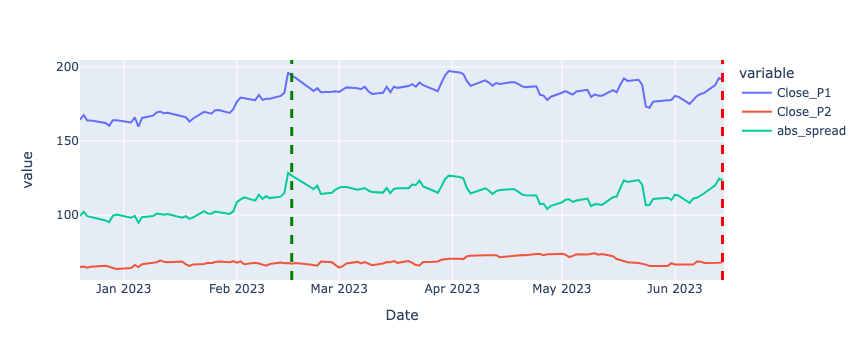

,exit_idx,entry_idx,stock1_price_entry,stock1_price_exit,stock2_price_entry,stock2_price_exit,long_stock_1,pnl,entry_dates,exit_dates
0,120,39,193.830002,191.889999,67.220001,68.169998,False,1.207072,2023-02-16,2023-06-14


In [133]:
fig = px.line(sub, x="Date", y=['Close_P1','Close_P2', 'abs_spread'])

for entry_date in trade_exec.entry_dates.values: 
    fig.add_vline(x=entry_date, line_width=3, line_dash="dash", line_color="green")
for exit_date in trade_exec.exit_dates.values: 
    fig.add_vline(x=exit_date, line_width=3, line_dash="dash", line_color="red")

fig.show()
trade_exec

In [ ]:
plt.plot(vec1_full, label='Stock1', color='green')
plt.plot(vec2_full, label='Stock2', color='blue')
# plt.plot(abs(vec1_full - vec2_full), label='Absolute Spread', color='grey')
plt.axvline(x=idx, color='red', linestyle='--', label='Vertical Line')
plt.axvline(x=idx-500, color='red', linestyle='--', label='Vertical Line')
plt.axvline(x=idx+120, color='red', linestyle='--', label='Vertical Line')

In [95]:
sub

,Date,Ticker_P1,Close_P1,Ticker_P2,Close_P2,abs_spread,abs_spread_mean,abs_spread_std,abs_spread_mean_l28,abs_spread_std_l28,...,abs_spread_normed_max,abs_spread_normed_90th,abs_spread_normed_75th,abs_spread_normed_median,abs_spread_normed_l7_avg,abs_spread_normed_l14_avg,cos_sim,corr_coef,pnls,trade_executions
3,2022-12-20,ADI,164.330002,EIX,64.879997,99.450005,99.42186,10.819426,102.406784,2.522386,...,3.449836,2.213829,1.848421,1.197308,0.287838,0.319037,0.995943,0.206178,0.012071,exit_idx entry_idx stock1_price_entry st...
4,2022-12-21,ADI,167.410004,EIX,65.220001,102.190002,99.46178,10.792656,102.482141,2.481485,...,3.449836,2.203648,1.834476,1.191793,0.250291,0.291818,0.995956,0.207518,0.022509,exit_idx entry_idx stock1_price_entry st...
5,2022-12-22,ADI,163.750000,EIX,64.500000,99.250000,99.49732,10.762540,102.305713,2.530686,...,3.449836,2.195105,1.823355,1.185732,0.144198,0.265603,0.995969,0.208322,0.036128,exit_idx entry_idx stock1_price_entry st...
6,2022-12-23,ADI,163.839996,EIX,65.180000,98.659996,99.52554,10.741747,102.209999,2.617747,...,3.449836,2.187836,1.818468,1.183435,0.093578,0.247181,0.995977,0.208661,0.026620,exit_idx entry_idx stock1_price_entry st...
7,2022-12-27,ADI,162.199997,EIX,65.820000,96.379997,99.54848,10.722703,101.919999,2.798215,...,3.449836,2.175288,1.812060,1.181847,0.135182,0.258650,0.995984,0.209380,0.040313,exit_idx entry_idx stock1_price_entry st...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,2023-06-07,ADI,180.369995,EIX,68.699997,111.669998,102.81784,11.958039,111.788571,5.211372,...,2.626903,1.731938,1.457948,0.845067,0.719627,0.929303,0.996253,0.380168,0.026583,exit_idx entry_idx stock1_price_entry st...
119,2023-06-08,ADI,181.679993,EIX,68.570000,113.109993,102.82454,11.962874,112.032499,5.102696,...,2.626903,1.729074,1.449609,0.845067,0.735731,0.865792,0.996263,0.381986,0.026583,exit_idx entry_idx stock1_price_entry st...
120,2023-06-09,ADI,182.460007,EIX,67.720001,114.740005,102.83596,11.971532,112.252142,5.081344,...,2.626903,1.727366,1.447442,0.845067,0.789521,0.819118,0.996272,0.383411,0.026583,exit_idx entry_idx stock1_price_entry st...
121,2023-06-12,ADI,187.660004,EIX,67.650002,120.010002,102.85950,11.993731,112.596071,5.272251,...,2.626903,1.718061,1.444127,0.845067,0.863161,0.796055,0.996278,0.384730,0.026583,exit_idx entry_idx stock1_price_entry st...


In [94]:
sub.trade_executions.values[0]

,exit_idx,entry_idx,stock1_price_entry,stock1_price_exit,stock2_price_entry,stock2_price_exit,long_stock_1,pnl,entry_dates,exit_dates
0,120,39,193.830002,191.889999,67.220001,68.169998,False,1.207072,2023-02-16,2023-06-14


In [83]:
np.where(sub.Date==date)[0][0]

0

In [ ]:
sub = tb[(tb.Ticker_P1==ticker1)&(tb.Ticker_P2==ticker2)]

In [76]:
def examine(tb, date, ticker1, ticker2):
    sub = tb[(tb.Ticker_P1==ticker1)&(tb.Ticker_P2==ticker2)]
combined.head()

,Date,Ticker_P1,Close_P1,Ticker_P2,Close_P2,abs_spread,abs_spread_mean,abs_spread_std,abs_spread_mean_l28,abs_spread_std_l28,...,abs_spread_normed_max,abs_spread_normed_90th,abs_spread_normed_75th,abs_spread_normed_median,abs_spread_normed_l7_avg,abs_spread_normed_l14_avg,cos_sim,corr_coef,pnls,trade_executions
0,2022-12-15,ADI,166.089996,AVB,168.789993,2.699997,47.85234,23.234631,4.246787,3.709966,...,2.744814,2.005332,1.481583,0.637567,2.022683,2.001837,0.994153,0.572016,0.0,None
1,2022-12-16,ADI,166.820007,AVB,165.000000,1.820007,47.82742,23.277353,3.844287,3.304175,...,2.744814,2.005332,1.481583,0.637567,2.017707,2.002000,0.994112,0.566356,0.0,None
2,2022-12-19,ADI,165.139999,AVB,162.220001,2.919998,47.80626,23.313402,3.591073,3.078103,...,2.744814,2.004832,1.481583,0.637567,1.994504,2.008078,0.994071,0.560720,0.0,None
3,2022-12-20,ADI,164.330002,AVB,161.210007,3.119995,47.78596,23.347928,3.318572,2.740031,...,2.744814,2.004832,1.481583,0.637567,1.975772,2.001524,0.994030,0.555516,0.0,None
4,2022-12-21,ADI,167.410004,AVB,162.369995,5.040009,47.76474,23.381990,3.089644,2.261476,...,2.744814,2.004832,1.481583,0.637567,1.944585,1.988568,0.993979,0.549435,0.0,None


In [75]:
temp = pnl_metadata_tb.dropna()
# temp
# temp.describe()
temp.trade_executions.values[0]

,exit_idx,entry_idx,stock1_price_entry,stock1_price_exit,stock2_price_entry,stock2_price_exit,long_stock_1,pnl,entry_dates,exit_dates
0,120,117,148.520004,147.600006,239.949997,241.119995,True,-0.553522,2022-03-08,2022-03-11


# Get the tech sector only

In [ ]:
with cProfile.Profile() as pr:
    recorded_info_tb, features_tb, labels_tb = generate_training_data(
        data=data_tech,
        training_len=500,
        test_len=120,
        sample_size_per_pair=10
    )

stats = pstats.Stats(pr)
stats.sort_stats(pstats.SortKey.TIME)
# Now you have two options, either print the data or save it as a file
stats.print_stats() # Print The Stats

In [ ]:
stats.dump_stats("logs/path.prof") # Saves the data

In [ ]:
combined = pd.merge(recorded_info_tb, features_tb, how='inner', on= ['ticker1','ticker2', 'target_date'])
combined = pd.merge(combined,labels_tb, how='inner', on= ['ticker1','ticker2', 'target_date'] )

In [ ]:
combined.to_csv('Data/tech_sector_pairs.csv', index=False)

In [ ]:
combined

# Get sampled combs

In [ ]:
(0.013090133666992188 * 124750)/60

In [ ]:
19900*0.28

In [ ]:
5572/60

In [ ]:
features_tb, labels_tb, pnl_metadata_tb = generate_training_data(
        data=data_sampled,
        training_len=500,
        test_len=120,
        calculate_label=True,
        calculate_feature=True
    )

In [ ]:
combined = pd.merge(recorded_info_tb, features_tb, how='inner', on= ['ticker1','ticker2', 'target_date'])
combined = pd.merge(combined,labels_tb, how='inner', on= ['ticker1','ticker2', 'target_date'] )
combined.to_csv('Data/sampled_sector_pairs_200.csv', index=False)

# Examining

In [ ]:
combined = pd.read_csv('Data/sampled_sector_pairs_200.csv')

In [ ]:
combined

In [ ]:
combined = combined.drop_duplicates().reset_index(drop=True)

In [ ]:
combined.shape

In [ ]:
combined.head()

In [ ]:
combined.shape

In [ ]:
random.choices()

In [ ]:
combined[['ticker1','ticker2']].groupby(['ticker1','ticker2']).size().sort_values()

In [ ]:
combined[(combined.ticker1=='COR')&(combined.ticker2=='META')].drop_duplicates()

In [ ]:
combined.total_pnl.describe()

In [ ]:
combined[combined.total_pnl>0.7]

In [ ]:
ticker1 = 'AOS'
ticker2 = 'AMD'
# Get a list of unique dates for later use
all_dates = data['Date'].unique()
vec1_full = data['Close'][data.Ticker==ticker1].values
vec2_full = data['Close'][data.Ticker==ticker2].values

In [ ]:
idx = np.where(all_dates=='2021-11-23')[0][0]

In [ ]:
plt.plot(vec1_full, label='Stock1', color='green')
plt.plot(vec2_full, label='Stock2', color='blue')
# plt.plot(abs(vec1_full - vec2_full), label='Absolute Spread', color='grey')
plt.axvline(x=idx, color='red', linestyle='--', label='Vertical Line')
plt.axvline(x=idx-500, color='red', linestyle='--', label='Vertical Line')
plt.axvline(x=idx+120, color='red', linestyle='--', label='Vertical Line')

In [ ]:
trade = ExecutePairTrading(
    abs_spread_mean=21.923220,
    abs_spread_std=15.530315
).execute(
vec1=vec1_full[idx:(idx+120)],
    vec2=vec2_full[idx:(idx+120)]
)

In [ ]:
trade.trade_execution_table

In [ ]:
plt.plot(vec1_full[idx:(idx+120)], label='Stock1', color='green')
plt.plot(vec2_full[idx:(idx+120)], label='Stock2', color='blue')
plt.axvline(x=1, color='red', linestyle='--', label='Vertical Line')
plt.axvline(x=106, color='red', linestyle='--', label='Vertical Line')

In [ ]:
trade.final_pl_pct

In [ ]:
trade.final_pl